In [ ]:
import os
import sys
import pandas as pd
import re, json
import pytesseract
import matplotlib.pyplot as plt


from dotenv import load_dotenv
from PIL import Image
from tempfile import NamedTemporaryFile
from io import BytesIO


project_root = os.path.abspath("..")
sys.path.append(project_root) 
load_dotenv(os.path.join(project_root, ".env"))
api_key = os.getenv("GENAI_API_KEY")
api_ocr_key = os.getenv("BG_OCR_API_KEY")
api_ocr_key2 = os.getenv("OCR_API_KEY")

from utils.utils import (
    VisionLanguageModel,
    DataUtils,
    prepare_content,
    get_answers_chunked,
    make_gold_file_json,
    visualize_image,
    get_answers, 
    extract_answer_bg,
    postprocess_regex,
    postprocess_regex_bg, 
    make_gold_file_json_bg
)

from utils.ocr import (
    ocr_space_file,
)

In [3]:
vlm = VisionLanguageModel(api_key=api_key)

In [ ]:
# make_gold_file_json_bg(
#     df=df,
#     path="../answers/val/gold_file_bg.json",
# )

Unknown answer key: A
Unknown answer key: A
Gold file saved to ../answers/val/gold_file_bg.json


In [4]:
df = DataUtils.load_parquet("../eval_pqs/bg_ocred_val.parquet")

Loaded DataFrame from ../eval_pqs/bg_ocred_val.parquet, shape=(400, 12)


In [5]:
df

,image,sample_id,answer_key,type,grade,subject,language,chemical_structure,table,figure,graph,ocr_text
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,f0d208e5-9a6d-4b26-9bdc-29f309040fed,А,image_text,[Grade: 4],Biology,Bulgarian,0.0,0.0,1.0,0.0,А ДА 48\n
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,44cfa1bc-2536-4def-823a-dff1682118a0,В,image_text,[Grade: 4],Biology,Bulgarian,0.0,0.0,1.0,0.0,6. Кои от небесните тела на схемата\nНЕ излъчв...
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,b8c31c0e-543b-4509-a675-e4fcfea5f546,А,image_text,[Grade: 4],Biology,Bulgarian,0.0,0.0,1.0,0.0,9. Разгледаи схемата. (С коя буква е\nозначен ...
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,e4ad5dc6-87ad-4330-bc04-9bcc847db12b,Б,image_text,[Grade: 4],Biology,Bulgarian,0.0,0.0,1.0,0.0,"10. Какъв вид движение извършват\nскиорите, ко..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,917b5df3-ac0b-4767-810e-23c51af82bd9,а,image_text,[Grade: 4],Biology,Bulgarian,0.0,0.0,1.0,0.0,14. За какво служи посочената част от\nскелета...
...,...,...,...,...,...,...,...,...,...,...,...,...
395,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3aa16d0e-90a3-419f-942d-c33e60112ebf,б,text,[Grade: 4],Sociology,Bulgarian,0.0,0.0,0.0,0.0,0. Какво се отглежда в Добруджа?\n\nа) рози\n0...
396,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6ba83f89-b94e-4095-8ca9-d34332d6f619,б,text,[Grade: 4],Sociology,Bulgarian,0.0,0.0,0.0,0.0,9. Коя трудова дейност застрашава\nприродата в...
397,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,312347e5-bbc5-47dc-9797-8d7019babe85,а,text,[Grade: 4],Sociology,Bulgarian,0.0,0.0,0.0,0.0,12. Кои български владетел пръв приема\nхристи...
398,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1bb2851e-9d2d-49a3-8a36-148b5e7baa9c,в,text,[Grade: 4],Sociology,Bulgarian,0.0,0.0,0.0,0.0,15. Кои цар премества столицата на\nБългария в...


In [6]:
df['answer_key'].unique()

array(['А', 'В', 'Б', 'а', 'в', 'б', 'Г', 'A'], dtype=object)

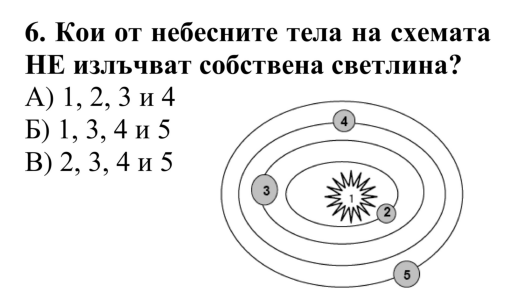

Predicted answer: В


In [6]:
row = df.iloc[1]
prompt, img = prepare_content(row, strict=True)
visualize_image(row["image"]["bytes"])

answer = vlm.get_answer(prompt, img, model="gemini-2.5-pro-exp-03-25", strict=True, thinking=False)
print(f"Predicted answer: {answer}")

In [7]:
df.iloc[1]["answer_key"]

'В'

In [7]:
prepare_content(df.iloc[0], strict=False, language="bg", ocr_enrichment=True)

('Ти си комплексен Vision-Language модел (VLM) способен да анализира изображения, съдържащи multiple-choice questions. В насочването на анализите си, подходи така:\n0. Вземи предвид, че предметът на въпроса е свързан с Biology и изборажението съдържа figure.\n-<begin-ocr>Вземи предвид OCR данните: А ДА 48\n<end-ocr>\n]n1. Анализ на изображение: Изследвай отблизо изображението, идентифицирай ключови елементи като текст, диаграми, и всякакви други релевантни характеристики.\n2. Извлечи текстът, който представлява въпроса\n3. Идентифицирай и извлечи опциите за отговор на въпроса \n    - Ако отговорите не са номерирани с букви, номерирай ги с български букви (А, Б, В, Г, Д)\n4. Потърси допълнителни визуални елементи, като таблици, диаграми, графики или диаграми.\n5. Увери се, че вземаш предвид всички многоезични или многодоменни аспекти на изображението, включително текст на различни езици или математическа/физична/научна нотация.\n6. Анализирай целия контекст и предоставените данни\n7. Из

In [ ]:
answers1, failures1 = get_answers_chunked(
    df=df,
    vlm=vlm,
    model="gemini-2.0-flash",
    strict=True, 
    language="bg",
    ocr_enrichment=True,
    step=10,
    thinking=False,
)
print(f"Got {len(answers1)} answers, failed on rows: {failures1}")




Got 400 answers, failed on rows: []


NameError: name 'answers' is not defined

In [9]:
DataUtils.save_to_json(answers1, "../outputs/predictions-val-bg-gemini-2.0-flash-2-1.json")

Saved JSON to ../outputs/predictions-val-bg-gemini-2.0-flash-2-1.json


In [10]:
answers1

[{'id': 'f0d208e5-9a6d-4b26-9bdc-29f309040fed',
  'answer_key': 'Анализирайки изображението, виждаме три везни. Всяка везна сравнява кубче с номер (1, 2 или 3) с тежест от 10 грама. Везните показват:\n\n1.  Кубче 1 е по-тежко от 10 грама (лявата везна е наклонена надолу при кубчето).\n2.  Кубче 2 е по-леко от 10 грама (средната везна е наклонена надолу при тежестта).\n3.  Кубче 3 е по-тежко от 10 грама (дясната везна е наклонена надолу при кубчето).\n\nСледователно, кубче 2 е с най-малка маса.\n\nБ',
  'language': 'Bulgarian'},
 {'id': '44cfa1bc-2536-4def-823a-dff1682118a0',
  'answer_key': 'В',
  'language': 'Bulgarian'},
 {'id': 'b8c31c0e-543b-4509-a675-e4fcfea5f546',
  'answer_key': 'A',
  'language': 'Bulgarian'},
 {'id': 'e4ad5dc6-87ad-4330-bc04-9bcc847db12b',
  'answer_key': 'Б',
  'language': 'Bulgarian'},
 {'id': '917b5df3-ac0b-4767-810e-23c51af82bd9',
  'answer_key': 'А',
  'language': 'Bulgarian'},
 {'id': '22bd8cc8-2817-4908-a557-c8a68cfaed8d',
  'answer_key': 'А',
  'langua

In [10]:
len(answers)

397

In [11]:
failures

[50, 72, 233]

In [24]:
# df

In [ ]:
retried = []
for _, row in df.iloc[failures].iterrows():
    ans = {}
    propmt, img = prepare_content(row, strict=True, language="bg")
    key = vlm._generate(
        model="gemini-2.0-flash",
        contents=[propmt, img],
        thinking=False,
    )
    ans["answer_key"] = key
    ans['language'] = "Bulgarian"
    ans["id"] = row['sample_id']

    retried.append(ans)


In [27]:
retried

[{'answer_key': 'Б',
  'language': 'bg',
  'id': '4424e5d8-9c6d-4adc-951b-d6cda11ef324'},
 {'answer_key': 'А',
  'language': 'bg',
  'id': 'f6dfdeab-0a4d-4cf3-a256-9300302a4567'},
 {'answer_key': 'Б',
  'language': 'bg',
  'id': '9d761790-ecf0-4e62-bb82-5f100c4914e3'}]

In [29]:
answers = answers + retried

In [30]:
len(answers)

400

In [19]:
with open("../outputs/predictions-val-bg-gemini-2.0-flash-1.json", "w") as f:
    json.dump(answers, f, indent=4)


In [28]:
with open("../outputs/predictions-val-bg-gemini-2.0-flash-2.json", "w") as f:
    json.dump(answers1, f, indent=4)

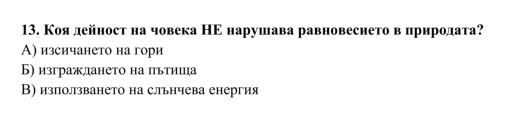

In [49]:
test_image = Image.open(BytesIO(df.iloc[10]['image']['bytes']))

plt.imshow(test_image)
plt.axis('off')
plt.show()

In [45]:
def ocr_df(df, lang='bul'):
    ocr_results = []
    for _, row in df.iterrows():
        image = Image.open(BytesIO(row['image']['bytes']))
        text = pytesseract.image_to_string(image, lang=lang)
        ocr_results.append(text)
    return ocr_results
ocr_results = ocr_df(df, lang='bul')
df['ocr_text'] = ocr_results

In [50]:
df['ocr_text'].iloc[10]

'13. Коя деиност на човека НЕК нарушава равновесието в природата?\nА) изсичането на гори\n\nБ) изграждането на пътища\n\nВ) използването на слънчева енергия\n'

In [88]:
def process_image(image):
    image = Image.open(BytesIO(image['bytes']))
    with NamedTemporaryFile(suffix=".jpg", delete=False) as temp_file:
        image.save(temp_file.name)
        temp_file_path = temp_file.name

    result = ocr_space_file(temp_file_path, api_ocr_key, language='bul', overlay=True)

    return result

In [90]:
from requests.exceptions import HTTPError

try:
	result = process_image(df.iloc[0]['image'])
	print(result)
except HTTPError as e:
	print(f"HTTPError occurred: {e}")
	print("Please check if the API key is valid and has the necessary permissions.")

HTTPError occurred: 403 Client Error: Forbidden for url: https://api.ocr.space/parse/image
Please check if the API key is valid and has the necessary permissions.


In [81]:
ocred_df = df.copy()

In [78]:
ocred_df

,image,sample_id,answer_key,type,grade,subject,language,chemical_structure,table,figure,graph
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,f0d208e5-9a6d-4b26-9bdc-29f309040fed,А,image_text,[Grade: 4],Biology,Bulgarian,0.0,0.0,1.0,0.0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,44cfa1bc-2536-4def-823a-dff1682118a0,В,image_text,[Grade: 4],Biology,Bulgarian,0.0,0.0,1.0,0.0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,b8c31c0e-543b-4509-a675-e4fcfea5f546,А,image_text,[Grade: 4],Biology,Bulgarian,0.0,0.0,1.0,0.0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,e4ad5dc6-87ad-4330-bc04-9bcc847db12b,Б,image_text,[Grade: 4],Biology,Bulgarian,0.0,0.0,1.0,0.0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,917b5df3-ac0b-4767-810e-23c51af82bd9,а,image_text,[Grade: 4],Biology,Bulgarian,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
395,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3aa16d0e-90a3-419f-942d-c33e60112ebf,б,text,[Grade: 4],Sociology,Bulgarian,0.0,0.0,0.0,0.0
396,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6ba83f89-b94e-4095-8ca9-d34332d6f619,б,text,[Grade: 4],Sociology,Bulgarian,0.0,0.0,0.0,0.0
397,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,312347e5-bbc5-47dc-9797-8d7019babe85,а,text,[Grade: 4],Sociology,Bulgarian,0.0,0.0,0.0,0.0
398,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1bb2851e-9d2d-49a3-8a36-148b5e7baa9c,в,text,[Grade: 4],Sociology,Bulgarian,0.0,0.0,0.0,0.0


In [14]:
answers

[{'id': 'f0d208e5-9a6d-4b26-9bdc-29f309040fed',
  'answer_key': 'From the image,\nQuestion: Кое кубче е с най-малка маса? Which cube has the smallest mass?\nOptions are:\nA) 1\nB) 2\nC) 3\n\nFrom the figure:\nCube 1 > 10g\nCube 2 < 10g\nCube 3 > 10g\n\nThe cube with the smallest mass is cube 2.\n\nB',
  'language': 'Bulgarian'},
 {'id': '44cfa1bc-2536-4def-823a-dff1682118a0',
  'answer_key': 'B',
  'language': 'Bulgarian'},
 {'id': 'b8c31c0e-543b-4509-a675-e4fcfea5f546',
  'answer_key': 'A',
  'language': 'Bulgarian'},
 {'id': 'e4ad5dc6-87ad-4330-bc04-9bcc847db12b',
  'answer_key': 'B',
  'language': 'Bulgarian'},
 {'id': '917b5df3-ac0b-4767-810e-23c51af82bd9',
  'answer_key': 'A',
  'language': 'Bulgarian'},
 {'id': '22bd8cc8-2817-4908-a557-c8a68cfaed8d',
  'answer_key': 'A',
  'language': 'Bulgarian'},
 {'id': '558bcd64-8770-47d8-9bb0-ecbd084ba07c',
  'answer_key': 'A',
  'language': 'Bulgarian'},
 {'id': '85a2a948-94b6-4871-956f-afe460dacee4',
  'answer_key': 'The arrow points to th

In [17]:
df_ans = pd.DataFrame(answers)

In [43]:
len([ans for ans in answers if ans["answer_key"] not in df["answer_key"].values])

85

In [16]:
for ans in answers1:
    match ans["answer_key"]:
        case "A":
            ans["answer_key"] = "А"
        case "B":
            ans["answer_key"] = "Б"
        case "C":
            ans["answer_key"] = "В"
        case "D":
            ans["answer_key"] = "Г"
        case "V":
            ans["answer_key"] = "В"
        case "G":
            ans["answer_key"] = "Г"

In [25]:
for ans in answers1:
    match ans["answer_key"]:
        case "А" | 'а':
            ans["answer_key"] = "A"
        case "Б" | 'б':
            ans["answer_key"] = "B"
        case "В" | 'в':
            ans["answer_key"] = "C"
        case "Г" | 'г':
            ans["answer_key"] = "D"
        case "Д" | 'д':
            ans["answer_key"] = "E"

In [27]:
[ans for ans in answers1 if ans["answer_key"] not in ["A", "B", "C", "D", "E"]]

[]

In [20]:
[(i, ans) for i, ans in enumerate(answers1) if ans["answer_key"] not in ["а", "б", "в", "г", "д", "А", "Б", "В", "Г", "Д"]]

[(0,
  {'id': 'f0d208e5-9a6d-4b26-9bdc-29f309040fed',
   'answer_key': 'Анализирайки изображението, виждаме три везни. Всяка везна сравнява кубче с номер (1, 2 или 3) с тежест от 10 грама. Везните показват:\n\n1.  Кубче 1 е по-тежко от 10 грама (лявата везна е наклонена надолу при кубчето).\n2.  Кубче 2 е по-леко от 10 грама (средната везна е наклонена надолу при тежестта).\n3.  Кубче 3 е по-тежко от 10 грама (дясната везна е наклонена надолу при кубчето).\n\nСледователно, кубче 2 е с най-малка маса.\n\nБ',
   'language': 'Bulgarian'})]

In [24]:
answers1[0] = {'id': 'f0d208e5-9a6d-4b26-9bdc-29f309040fed',
   'answer_key': 'Б',
   'language': 'Bulgarian'}

In [54]:
for id, ans in [(id, ans) for id, ans in enumerate(answers) if ans["answer_key"] not in df["answer_key"].values]:
    visualize_image(df[df["sample_id"] == ans["id"]].iloc[0]["image"]["bytes"])
    print(id)

In [37]:
for ans in answers[-3:]:
    ans['language'] = "Bulgarian"

In [44]:
postprocess_regex_bg(answers)

In [15]:
answers

[{'id': 'f0d208e5-9a6d-4b26-9bdc-29f309040fed',
  'answer_key': 'Б',
  'language': 'Bulgarian'},
 {'id': '44cfa1bc-2536-4def-823a-dff1682118a0',
  'answer_key': 'Б',
  'language': 'Bulgarian'},
 {'id': 'b8c31c0e-543b-4509-a675-e4fcfea5f546',
  'answer_key': 'А',
  'language': 'Bulgarian'},
 {'id': 'e4ad5dc6-87ad-4330-bc04-9bcc847db12b',
  'answer_key': 'Б',
  'language': 'Bulgarian'},
 {'id': '917b5df3-ac0b-4767-810e-23c51af82bd9',
  'answer_key': 'А',
  'language': 'Bulgarian'},
 {'id': '22bd8cc8-2817-4908-a557-c8a68cfaed8d',
  'answer_key': 'А',
  'language': 'Bulgarian'},
 {'id': '558bcd64-8770-47d8-9bb0-ecbd084ba07c',
  'answer_key': 'Б',
  'language': 'Bulgarian'},
 {'id': '85a2a948-94b6-4871-956f-afe460dacee4',
  'answer_key': 'Б',
  'language': 'Bulgarian'},
 {'id': '2604fe9a-ac1c-4ecf-af30-e44d66babf46',
  'answer_key': 'А',
  'language': 'Bulgarian'},
 {'id': '969ac241-6b9c-4dd7-bc69-8bea251492e2',
  'answer_key': 'Б',
  'language': 'Bulgarian'},
 {'id': 'ca037969-a0c3-4d09-9e

In [ ]:
with open("../outputs/predictions-val-bg-gemini-2.0-flash.json", "r") as f:
    answers = json.load(f)

In [52]:
answers[227]['answer_key'] = 'Г'

In [50]:
answers[130]['answer_key'] = 'В'

In [51]:
answers1[227]["answer_key"]

'Γ'

In [ ]:
# df.to_parquet("../eval_pqs/bg_ocred_val.parquet", index=False)

In [31]:
answers2, failures2 = get_answers_chunked(
    df=df,
    vlm=vlm,
    model="gemini-2.5-flash-preview-04-17",
    strict=True, 
    language="bg",
    ocr_enrichment=True,
    step=10,
    thinking=True,
)
print(f"Got {len(answers2)} answers, failed on rows: {failures2}")

Error in _generate: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Attempt 1 for get_answer failed: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}. Retrying in 1.0s...
Error in _generate: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Attempt 1 for get_answer failed: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}. Retrying in 1.0s...
Error in _generate: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Attempt 1 for get_answer failed: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}. Retrying in 1.0s..

In [33]:
[(i, ans) for i, ans in enumerate(answers2) if ans['answer_key'] not in ['А', 'Б', 'В', 'Г', 'Д']]

[(301,
  {'id': '19d6d8a2-a56c-46da-8cbd-7e7127a29c15',
   'answer_key': 'а',
   'language': 'Bulgarian'}),
 (389,
  {'id': '6397ee04-7bd1-4a69-b6e5-a400d2650ebc',
   'answer_key': 'а',
   'language': 'Bulgarian'}),
 (397,
  {'id': '312347e5-bbc5-47dc-9797-8d7019babe85',
   'answer_key': 'а',
   'language': 'Bulgarian'})]

In [34]:
for ans in answers2:
    match ans["answer_key"]:
        case "А" | 'а':
            ans["answer_key"] = "A"
        case "Б" | 'б':
            ans["answer_key"] = "B"
        case "В" | 'в':
            ans["answer_key"] = "C"
        case "Г" | 'г':
            ans["answer_key"] = "D"
        case "Д" | 'д':
            ans["answer_key"] = "E"

In [35]:
len([ans for ans in answers2 if ans['answer_key'] not in ['A', 'B', 'C', 'D', 'E']])

0

In [36]:
with open("../outputs/predictions-val-bg-gemini-2.5-flash.json", "w") as f:
    json.dump(answers2, f, indent=4)